In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("Fraud Detection - Logistic Regression") \
    .getOrCreate()
spark

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)# Property used to format output tables better

df = spark.read.csv("hdfs://namenode:9000/user/data/Fraud.csv", inferSchema=True, header=True)
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

# Data Exploration

In [4]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [5]:
df.count()

6362620

In [6]:
df.select("*").distinct().count()

6362620

# Preprocessing

## Simplde feature selection

In [7]:
df = df.select("step", "type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud")
df.show(5)

+----+--------+--------+-------------+--------------+--------------+--------------+-------+
|step|    type|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+--------+-------------+--------------+--------------+--------------+-------+
|   1| PAYMENT| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|
|   1| PAYMENT| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|
|   1|TRANSFER|   181.0|        181.0|           0.0|           0.0|           0.0|      1|
|   1|CASH_OUT|   181.0|        181.0|           0.0|       21182.0|           0.0|      1|
|   1| PAYMENT|11668.14|      41554.0|      29885.86|           0.0|           0.0|      0|
+----+--------+--------+-------------+--------------+--------------+--------------+-------+
only showing top 5 rows



## Train test split

In [8]:
train, test = df.randomSplit([0.7, 0.3], seed=5624)

In [9]:
train.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)



## Handling Categorical columns

### String indexer

In [10]:
# Define StringIndexer for categorical column
string_indexer = [StringIndexer(inputCol="type",
                                outputCol="type_StringIndexer",
                                handleInvalid="skip")]

### One-Hot Encoding

In [11]:
from pyspark.ml.feature import OneHotEncoder

# Define OneHotEncoder for the indexed column
one_hot_encoder = [OneHotEncoder(inputCols=["type_StringIndexer"],
                                 outputCols=["type_OneHotEncoder"])]


## Scaling Numeric Columns

In [16]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Define the numeric columns
numeric_columns = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

# Assemble numeric columns into a single vector
numeric_vector_col = "numeric_features"
numeric_vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol=numeric_vector_col)

# Apply StandardScaler to the numeric vector
scaled_numeric_vector_col = "scaled_numeric_features"
standard_scaler = StandardScaler(inputCol=numeric_vector_col,
                                 outputCol=scaled_numeric_vector_col,
                                 withMean=True,   # Center the data
                                 withStd=True)    # Scale to unit variance

# Collect these stages
scaler_stages = [numeric_vector_assembler, standard_scaler]


## Combining Features with VectorAssembler

In [17]:
# Define input columns for the VectorAssembler
assemblerInput = [scaled_numeric_vector_col, "isFraud", "type_OneHotEncoder"]

# Define VectorAssembler
vector_assembler = VectorAssembler(inputCols=assemblerInput,
                                   outputCol="VectorAssembler_features")

## Building the Pipeline

In [18]:
from pyspark.ml import Pipeline

# Combine all stages
stages = []
stages += string_indexer
stages += one_hot_encoder
stages += scaler_stages  # Add scalers for numeric columns
stages += [vector_assembler]

# Define the pipeline
pipeline = Pipeline(stages=stages)


## Fitting and Transforming Data

In [20]:
# Fit the pipeline on the training data
model = pipeline.fit(train)

# Transform data
transformed_train_data = model.transform(train)
transformed_test_data = model.transform(test)


## Selecting Features and label 

In [21]:
train_data = transformed_train_data.select(F.col("VectorAssembler_features").alias("features"),
                                    F.col("isFraud").alias("label"))

test_data = transformed_test_data.select(F.col("VectorAssembler_features").alias("features"),
                                  F.col("isFraud").alias("label"))

train_data.show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
|[-1.7028854456403...|    0|
+--------------------+-----+
only showing top 10 rows



# Training the model

In [24]:
lr_spark = LogisticRegression().fit(train_data)

In [25]:
# Make predictions on the test data
predictions = lr_spark.transform(test_data)

# Evaluating the model 

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# AUC (Area Under ROC)
auc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# AUC-PR (Area Under Precision-Recall Curve)
auc_pr_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderPR")
auc_pr = auc_pr_evaluator.evaluate(predictions)
print(f"AUC-PR: {auc_pr}")


AUC: 1.0
AUC-PR: 1.0


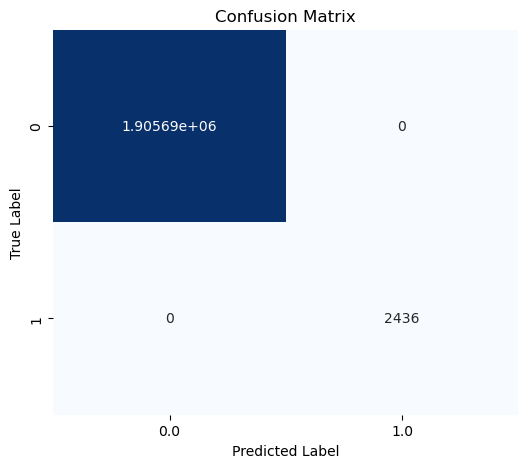

In [36]:
# Create a confusion matrix DataFrame
confusion_matrix = predictions.groupBy("prediction", "label").count().toPandas()

# Reshape the confusion matrix for easy plotting
confusion_matrix_pivot = confusion_matrix.pivot(index="label", columns="prediction", values="count").fillna(0)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
